In [1]:
%pip install -U imbalanced-learn
%pip install fairlearn
%pip install yellowbrick


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, multilabel_confusion_matrix, precision_recall_fscore_support, plot_roc_curve, plot_confusion_matrix, plot_precision_recall_curve, plot_det_curve
import matplotlib.pyplot as plt
from yellowbrick.classifier import ROCAUC
from sklego.metrics import p_percent_score
from yellowbrick.classifier import ConfusionMatrix

In [3]:
refugee = pd.read_csv('1milrefugee_accept_final_dataset.csv', index_col=0)

In [4]:
df = refugee.copy()

In [5]:
df.tail()

,language,education_level,last_occupation,qualified_for_unhcr_mandatory_contribution
999995,Native + English,Undergrad,Junior DevOps Professional,accepted
999996,Native,Primary,Not employed,not accepted
999997,Native + English,No Education,Construction Worker,not accepted
999998,Native + English,Masters,Senior Administrative Assistant,not accepted
999999,Native + French,High School,Baker,not accepted


In [6]:
df['qualified_for_unhcr_mandatory_contribution'].value_counts()

not accepted    731932
accepted        268068
Name: qualified_for_unhcr_mandatory_contribution, dtype: int64

In [7]:
#Divide the data based on their catageory
target_variable = 'qualified_for_unhcr_mandatory_contribution'
encode_variable = ['language', 'education_level', 'last_occupation']

In [8]:
#OneHotEncoding for the features
for col in encode_variable:
    dummy_data = pd.get_dummies(df[col], prefix=col)
    df = pd.concat([df, dummy_data], axis=1)
    del df[col]

In [9]:
#Label encoding for the feature to maintain the importance of the label values
mapping_target = {'accepted':0, 'not accepted':1}
def encoded_target(val):
    return mapping_target[val]

In [10]:
#Joining the two encoded datasets into one
df['qualified_for_unhcr_mandatory_contribution'] = df['qualified_for_unhcr_mandatory_contribution'].apply(encoded_target)

In [11]:
#Dividing the new datset into X(features) and y(target-label) 
X = df.drop('qualified_for_unhcr_mandatory_contribution', axis=1)
y = df['qualified_for_unhcr_mandatory_contribution']

In [12]:
y.value_counts()

1    731932
0    268068
Name: qualified_for_unhcr_mandatory_contribution, dtype: int64

In [13]:
#Splitting the data before rescaling to reduce the chances of data leakage and overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

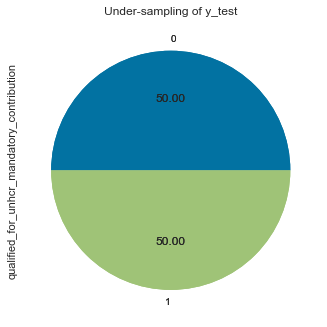

In [14]:
#Using random sampling instead of oversampling to reduce dataleakage, overfitting and duplicate data creation
from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(sampling_strategy=1) # Numerical value
rus = RandomUnderSampler(sampling_strategy="not minority") # String
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)

ax1 = y_train.value_counts().plot.pie(autopct='%.2f')
_1 = ax1.set_title("Under-sampling of y_train")
ax2 = y_test.value_counts().plot.pie(autopct='%.2f')
_2 = ax2.set_title("Under-sampling of y_test")

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [16]:
#Using robustscaler for outliers and also do the scaling after the split to prevent data lickage
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()
min_max.fit(X_train)
X_train = min_max.fit_transform(X_train)
X_test = min_max.transform(X_test)

In [18]:
#Applying the PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.99)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [19]:
y_test.value_counts()

0    53838
1    53838
Name: qualified_for_unhcr_mandatory_contribution, dtype: int64

In [20]:
 #The number of PC used
 pca.n_components_ 

71

Training Score
- accuracy: 0.91212248517948
- matthews cofficient: 0.8244078271029281
Testing Score
- accuracy: 0.911920948029273
- matthews cofficient: 0.8239795330157318


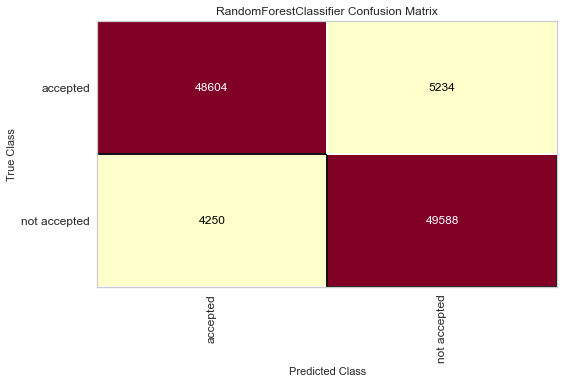

              precision    recall  f1-score   support

           0       0.92      0.90      0.91    214230
           1       0.90      0.92      0.91    214230

    accuracy                           0.91    428460
   macro avg       0.91      0.91      0.91    428460
weighted avg       0.91      0.91      0.91    428460

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     53838
           1       0.90      0.92      0.91     53838

    accuracy                           0.91    107676
   macro avg       0.91      0.91      0.91    107676
weighted avg       0.91      0.91      0.91    107676



In [21]:
#Model1-RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.metrics import matthews_corrcoef
#Making the model
rf_c = RandomForestClassifier(n_estimators=2000, class_weight={0:1,1:3})
#rf_c = RandomForestClassifier()
rf_c.fit(X_train, y_train)

#Predicting
y_train_pred = rf_c.predict(X_train) 
y_test_pred = rf_c.predict(X_test)

#Scoring
rf_c_train_acu = accuracy_score(y_train,y_train_pred)
rf_c_train_mcc = matthews_corrcoef(y_train, y_train_pred)

rf_c_test_acu = accuracy_score(y_test,y_test_pred)
rf_c_test_mcc = matthews_corrcoef(y_test, y_test_pred)

print('Training Score')
print('- accuracy: %s' % rf_c_train_acu)
print('- matthews cofficient: %s' % rf_c_train_mcc)
print('Testing Score')
print('- accuracy: %s' % rf_c_test_acu)
print('- matthews cofficient: %s' % rf_c_test_mcc)

#Confusion Metrics
rf_c_cm = ConfusionMatrix(
    rf_c, classes = ['accepted', 'not accepted'])
    


rf_c_cm.fit(X_train, y_train)
rf_c_cm.score(X_test, y_test)
rf_c_cm.show()


print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))


# Creating binary ROAUC visualization with the readable labels
#visualizer = ROCAUC(rf_c, classes = ['accepted', 'not accepted'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
#visualizer.fit(X_train, y_train)
#visualizer.score(X_test, y_test)
#visualizer.show()

#DiscriminationThreshold
#visualizer = DiscriminationThreshold(rf_c)

# Fit and show the data using the visualizer
#visualizer.fit(X_train, y_train)        
#visualizer.show()           

Training Score
- accuracy: 0.935797974139943
- matthews cofficient: 0.8770554062666727
Testing Score
- accuracy: 0.9355195215275456
- matthews cofficient: 0.8765230581850161


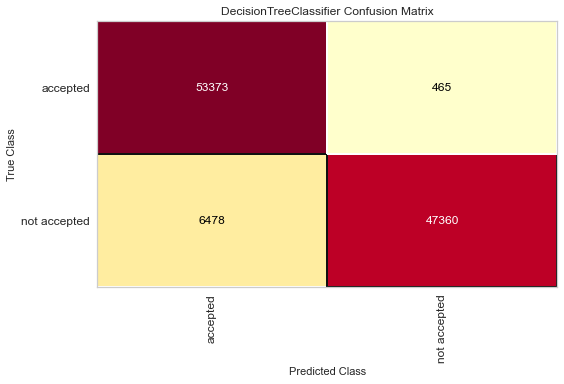

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    214230
           1       0.99      0.88      0.93    214230

    accuracy                           0.94    428460
   macro avg       0.94      0.94      0.94    428460
weighted avg       0.94      0.94      0.94    428460

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     53838
           1       0.99      0.88      0.93     53838

    accuracy                           0.94    107676
   macro avg       0.94      0.94      0.94    107676
weighted avg       0.94      0.94      0.94    107676



In [22]:
#Model2- DecissionTree Classifier 

from sklearn.tree import DecisionTreeClassifier
#Making the model
#dt = DecisionTreeClassifier(max_depth=5)
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

#Predicting
y_train_pred = dt.predict(X_train) 
y_test_pred = dt.predict(X_test)

#Scoring
dt_train_acu = accuracy_score(y_train,y_train_pred)
dt_train_mcc = matthews_corrcoef(y_train, y_train_pred)

dt_test_acu = accuracy_score(y_test,y_test_pred)
dt_test_mcc = matthews_corrcoef(y_test, y_test_pred)

print('Training Score')
print('- accuracy: %s' % dt_train_acu)
print('- matthews cofficient: %s' % dt_train_mcc)
print('Testing Score')
print('- accuracy: %s' % dt_test_acu)
print('- matthews cofficient: %s' % dt_test_mcc)

#Confusion Metrics
dt_cm = ConfusionMatrix(
    dt, classes = ['accepted', 'not accepted'])
    


dt_cm.fit(X_train, y_train)
dt_cm.score(X_test, y_test)
dt_cm.show()


print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

# Creating binary ROAUC visualization with the readable labels
#visualizer = ROCAUC(dt, classes = ['accepted', 'not accepted'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
#visualizer.fit(X_train, y_train)
#visualizer.score(X_test, y_test)
#visualizer.show()

#DiscriminationThreshold
#visualizer = DiscriminationThreshold(dt)

# Fit and show the data using the visualizer
#visualizer.fit(X_train, y_train)        
#visualizer.show()       

In [23]:
#Model3 - SupportVector Classifier

#from sklearn.svm import SVC

#Making the model
#vm_rbf = SVC(gamma=2, C=1)
#svm_rbf = SVC()
#svm_rbf.fit(X_train, y_train)

#Predicting
#y_train_pred = svm_rbf.predict(X_train) 
#y_test_pred = svm_rbf.predict(X_test)

#Scoring
#svm_rbf_train_acu = accuracy_score(y_train,y_train_pred)
#svm_rbf_train_mcc = matthews_corrcoef(y_train, y_train_pred)

#svm_rbf_test_acu = accuracy_score(y_test,y_test_pred)
#svm_rbf_test_mcc = matthews_corrcoef(y_test, y_test_pred)

#print('Training Score')
#print('- accuracy: %s' % svm_rbf_train_acu)
#print('- matthews cofficient: %s' % svm_rbf_train_mcc)
#print('Testing Score')
#print('- accuracy: %s' % svm_rbf_test_acu)
#print('- matthews cofficient: %s' % svm_rbf_test_mcc)

#Confusion Metrics
#svm_rbf_cm = ConfusionMatrix(
#    svm_rbf, classes = ['accepted', 'not accepted'])
    


#svm_rbf_cm.fit(X_train, y_train)
#svm_rbf_cm.score(X_test, y_test)
#svm_rbf_cm.show()

#print(classification_report(y_train, y_train_pred))
#print(classification_report(y_test, y_test_pred))

# Creating binary ROAUC visualization with the readable labels
#visualizer = ROCAUC(svm_rbf, classes = ['accepted', 'not accepted']) #, binary=True

                                        
# Fitting to the training data first then scoring with the test data                                    
#visualizer.fit(X_train, y_train)
#visualizer.score(X_test, y_test)
#visualizer.show()

#DiscriminationThreshold
#visualizer = DiscriminationThreshold(svm_rbf)

# Fit and show the data using the visualizer
#visualizer.fit(X_train, y_train)        
#visualizer.show()       

Training Score
- matthews cofficient: 0.8776619881766162
- accuracy: 0.8776619881766162
Testing Score
- matthews cofficient: 0.8712808766692208
- accuracy: 0.8712808766692208


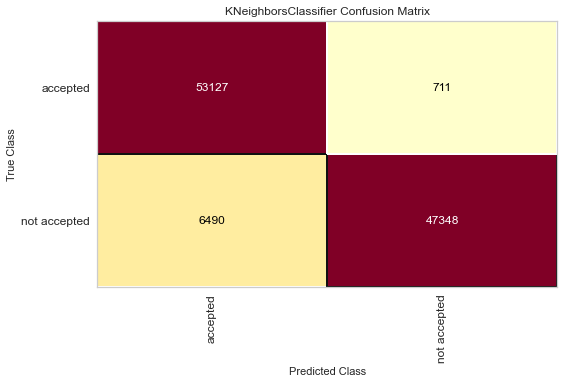

              precision    recall  f1-score   support

           0       0.89      0.99      0.94    214230
           1       0.99      0.88      0.93    214230

    accuracy                           0.94    428460
   macro avg       0.94      0.94      0.94    428460
weighted avg       0.94      0.94      0.94    428460

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     53838
           1       0.99      0.88      0.93     53838

    accuracy                           0.93    107676
   macro avg       0.94      0.93      0.93    107676
weighted avg       0.94      0.93      0.93    107676



In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
#Predicting
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
#Scoring
knn_mcc_train = matthews_corrcoef(y_train, y_train_pred)
knn_acc_train = accuracy_score(y_train,y_train_pred)

knn_mcc_test = matthews_corrcoef(y_test, y_test_pred)
knn_acc_test = accuracy_score(y_test,y_test_pred)

print('Training Score')
print('- matthews cofficient: %s' % knn_mcc_train)
print('- accuracy: %s' % knn_mcc_train)
print('Testing Score')
print('- matthews cofficient: %s' % knn_mcc_test)
print('- accuracy: %s' % knn_mcc_test)

#Confusion Metrics
knn_cm = ConfusionMatrix(
    knn, classes = ['accepted', 'not accepted'])
    


knn_cm.fit(X_train, y_train)
knn_cm.score(X_test, y_test)
knn_cm.show()

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

# Creating binary ROAUC visualization with the readable labels
#visualizer = ROCAUC(knn, classes = ['accepted', 'not accepted'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
#visualizer.fit(X_train, y_train)
#visualizer.score(X_test, y_test)
#visualizer.show()

#DiscriminationThreshold
#visualizer2 = DiscriminationThreshold(knn)

# Fit and show the data using the visualizer
#visualizer2.fit(X_train, y_train)        
#visualizer2.show()       

Training Score
- accuracy: 0.9031601549736265
- matthews cofficient: 0.806340340231165
Testing Score
- accuracy: 0.9040733311044243
- matthews cofficient: 0.8081573589260037


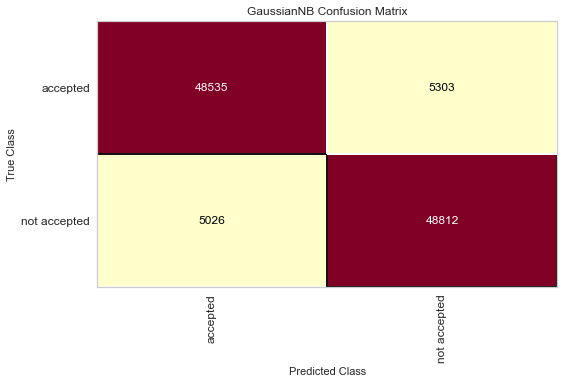

              precision    recall  f1-score   support

           0       0.91      0.90      0.90    214230
           1       0.90      0.91      0.90    214230

    accuracy                           0.90    428460
   macro avg       0.90      0.90      0.90    428460
weighted avg       0.90      0.90      0.90    428460

              precision    recall  f1-score   support

           0       0.91      0.90      0.90     53838
           1       0.90      0.91      0.90     53838

    accuracy                           0.90    107676
   macro avg       0.90      0.90      0.90    107676
weighted avg       0.90      0.90      0.90    107676



In [25]:
from sklearn.naive_bayes import GaussianNB

#Making the model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

#Predicting
y_train_pred = gnb.predict(X_train) 
y_test_pred = gnb.predict(X_test)

#Scoring
gnb_train_acu = accuracy_score(y_train,y_train_pred)
gnb_train_mcc = matthews_corrcoef(y_train, y_train_pred)

gnb_test_acu = accuracy_score(y_test,y_test_pred)
gnb_test_mcc = matthews_corrcoef(y_test, y_test_pred)

print('Training Score')
print('- accuracy: %s' % gnb_train_acu)
print('- matthews cofficient: %s' % gnb_train_mcc)
print('Testing Score')
print('- accuracy: %s' % gnb_test_acu)
print('- matthews cofficient: %s' % gnb_test_mcc)

#Confusion Metrics
gnb_cm = ConfusionMatrix(
    gnb, classes = ['accepted', 'not accepted'])
    


gnb_cm.fit(X_train, y_train)
gnb_cm.score(X_test, y_test)
gnb_cm.show()

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

# Creating binary ROAUC visualization with the readable labels
#visualizer = ROCAUC(gnb, classes = ['accepted', 'not accepted'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
#visualizer.fit(X_train, y_train)
#visualizer.score(X_test, y_test)
#isualizer.show()

#DiscriminationThreshold
#visualizer = DiscriminationThreshold(gnb)

# Fit and show the data using the visualizer
#visualizer.fit(X_train, y_train)        
#visualizer.show()  

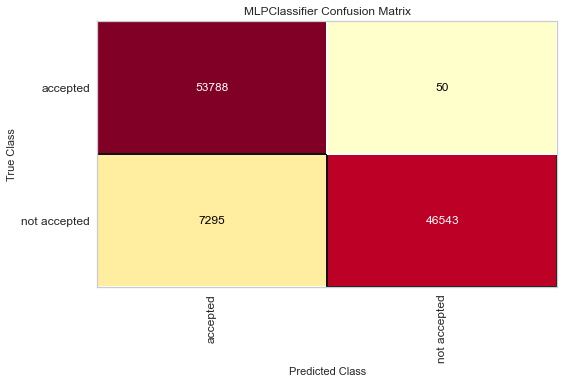

              precision    recall  f1-score   support

           0       0.88      1.00      0.94    214230
           1       1.00      0.86      0.93    214230

    accuracy                           0.93    428460
   macro avg       0.94      0.93      0.93    428460
weighted avg       0.94      0.93      0.93    428460

              precision    recall  f1-score   support

           0       0.88      1.00      0.94     53838
           1       1.00      0.86      0.93     53838

    accuracy                           0.93    107676
   macro avg       0.94      0.93      0.93    107676
weighted avg       0.94      0.93      0.93    107676



In [26]:
from sklearn.neural_network import MLPClassifier

#Making the model
mlp = MLPClassifier(alpha=1, max_iter=1000)
#mlp = MLPClassifier()
mlp.fit(X_train, y_train)

#Predicting
y_train_pred = mlp.predict(X_train) 
y_test_pred = mlp.predict(X_test)

#Scoring
mlp_train_acu = accuracy_score(y_train,y_train_pred)
mlp_train_mcc = matthews_corrcoef(y_train, y_train_pred)

mlp_test_acu = accuracy_score(y_test,y_test_pred)
mlp_test_mcc = matthews_corrcoef(y_test, y_test_pred)

#Confusion Metrics
mlp_cm = ConfusionMatrix(
    mlp, classes = ['accepted', 'not accepted'])
    


mlp_cm.fit(X_train, y_train)
mlp_cm.score(X_test, y_test)
mlp_cm.show()

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

# Creating binary ROAUC visualization with the readable labels
#visualizer = ROCAUC(mlp, classes = ['accepted', 'not accepted'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
#visualizer.fit(X_train, y_train)
#visualizer.score(X_test, y_test)
#visualizer.show()

#DiscriminationThreshold
#visualizer = DiscriminationThreshold(mlp)

# Fit and show the data using the visualizer
#visualizer.fit(X_train, y_train)        
#visualizer.show()  

Training Score
- accuracy: 0.9342038930121832
- matthews cofficient: 0.8716863487719478
Testing Score
- accuracy: 0.9345722352241911
- matthews cofficient: 0.8725255278489777


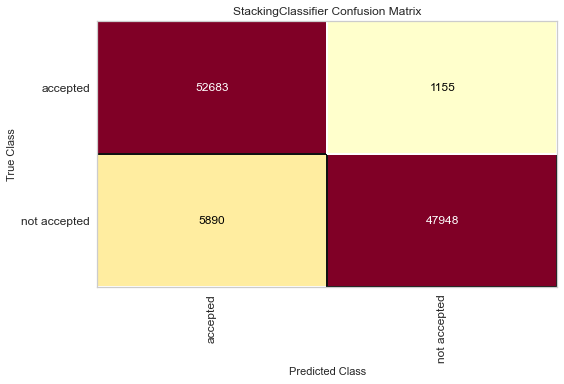

              precision    recall  f1-score   support

           0       0.90      0.98      0.94    214230
           1       0.98      0.89      0.93    214230

    accuracy                           0.93    428460
   macro avg       0.94      0.93      0.93    428460
weighted avg       0.94      0.93      0.93    428460

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     53838
           1       0.98      0.89      0.93     53838

    accuracy                           0.93    107676
   macro avg       0.94      0.93      0.93    107676
weighted avg       0.94      0.93      0.93    107676



In [27]:
#The final stacked model

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
              #('svm_rbf',svm_rbf),
              ('dt',dt),
              ('rf_c',rf_c),
]

#Making the model
stack_m = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(max_iter=1000)
)
stack_m.fit(X_train, y_train)

#Predicting
y_train_pred = stack_m.predict(X_train) 
y_test_pred = stack_m.predict(X_test)

#Scoring
stack_m_train_acu = accuracy_score(y_train,y_train_pred)
stack_m_train_mcc = matthews_corrcoef(y_train, y_train_pred)

stack_m_test_acu = accuracy_score(y_test,y_test_pred)
stack_m_test_mcc = matthews_corrcoef(y_test, y_test_pred)

print('Training Score')
print('- accuracy: %s' % stack_m_train_acu)
print('- matthews cofficient: %s' % stack_m_train_mcc)
print('Testing Score')
print('- accuracy: %s' % stack_m_test_acu)
print('- matthews cofficient: %s' % stack_m_test_mcc)

#Confusion Metrics
stack_m_cm = ConfusionMatrix(
    stack_m, classes = ['accepted', 'not accepted'])
    


stack_m_cm.fit(X_train, y_train)
stack_m_cm.score(X_test, y_test)
stack_m_cm.show()

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

# Creating binary ROAUC visualization with the readable labels
#visualizer = ROCAUC(stack_m, classes = ['accepted', 'not accepted'])
                    

                                        
# Fitting to the training data first then scoring with the test data                                    
#visualizer.fit(X_train, y_train)
#visualizer.score(X_test, y_test)
#visualizer.show()

#DiscriminationThreshold
#visualizer = DiscriminationThreshold(stack_m)

# Fit and show the data using the visualizer
#visualizer.fit(X_train, y_train)        
#visualizer.show()  

In [28]:
#import joblib
#range_model = "range_main_model.pkl"
#joblib.dump(model_name, range_model)